In [23]:
import math
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from data_loader import LoadData, LoadDataShort
import numpy as np
import sys 
from data_loader import LoadDataLSTM, LoadData_StartEndLong
from networks.rnn import LSTM
from networks.mlp import MLP
from networks.trans import MLP_MULTIDECODE
import time 
import copy 
import matplotlib.pyplot as plt
from utils import load_data, create_model

In [24]:
class args:
    def __init__(self,hidden_dims=32,layers=3,PREVIOUS_FRaMES=5):
        hidden_dim = hidden_dims
        layers= layers
        PREVIOUS_FRaMES = PREVIOUS_FRaMES

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

test data shape (61, 500, 2) 0.00231162 1.99635
start loading
Model Loaded!
Runtime of the loading model is 0.19976806640625
Runtime of the predictiong is 11.42394757270813
model error: 
max: 1.0179404600206876
min: 0.0
mean: 0.05817902508747063
median: 0.02666523874762797


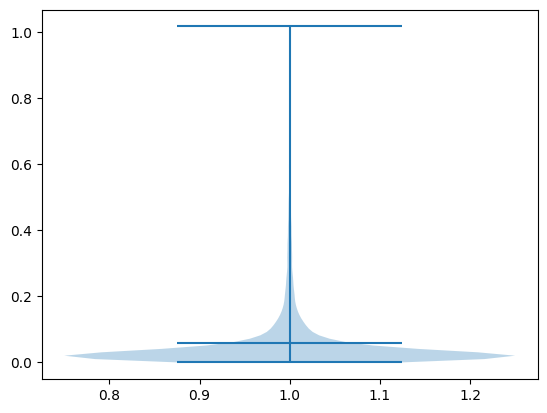

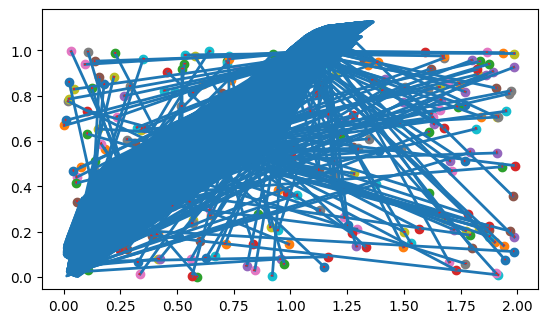

In [25]:
#np.random.seed(seed = int(time.time() + 0))
#Start, End
s,e = 0,60
interval = 1
batch_size = 500
dim = 2
t_start = 0
minval = 0
maxval = 1
dataset = "double_gyre"
dim = 2 # the dimension of dataset

model_dir = "/home/maanav/dataset/flowlearn/path-line-ml/network_pytorch/checkpoints/double_gyre_short/double_gyre_short_1000_MLP/model_final.pth"

index = "4400"

## load test data [this is the ground truth without normalization]
test_data_dir = "/home/maanav/dataset/flowlearn/path-line-ml/network_pytorch/data/500_short.npy"  ## this data shape is [61, 500, 3]
gt = np.load(test_data_dir) 
print("test data shape", gt.shape, np.min(gt[0, :, 0]), np.max(gt[0, :, 0])) 

num_fm = gt.shape[0] - 1 ## number of time steps 

## Remove seeds within the offset of boundary if needed 
offset = 0.0
lower = [0, 0]
upper = [2, 1] ## double gyre 
bbox_lower = [lower[0] + offset, lower[1] + offset]
bbox_upper = [upper[0] - offset, upper[1] - offset]

x_min = np.min(gt[:,:,0]) # x_min, x_max, y_min, y_max are the boundings of the domain
x_max = np.max(gt[:,:,0]) 
y_min = np.min(gt[:,:,1]) 
y_max = np.max(gt[:,:,1]) 

minval = 0
maxval = 1
t_min = 0
t_max = gt.shape[0] - 1

seeds = gt[0, :, 0:dim]

seeds_normalized = np.copy(seeds)

seeds_normalized[:, 0] =   (seeds[:, 0] - x_min) / (x_max - x_min) * (maxval - minval) + minval

seeds_normalized[:, 1] = (seeds[:, 0] - y_min) / (y_max - y_min) * (maxval - minval) + minval
num_seeds = seeds.shape[0]


# seeds_copy = copy.deepcopy(seeds)

## Load model 
start = time.time()
print("start loading")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP()

if device == torch.device("cpu"):
    model.load_state_dict(torch.load(model_dir, map_location=device))
else:
    model.load_state_dict(torch.load(model_dir))

model.to(device)
print("Model Loaded!")
end = time.time()
print(f"Runtime of the loading model is {end - start}")

## Calculating the inference
start_time = time.time()

fms = np.zeros((num_fm+1, num_seeds, dim)) # reconstruct the results shape 
fms[0, :, :] = seeds
results = np.zeros((num_fm * num_seeds, dim))
all_ouput = []
for ts in range(num_fm):
    #results = np.zeros((num_seeds, dim)) ## save the results from the prediction for one time step
    # calculate time for each time step 
    # Note: check if my calculate is matched to the time you used for generating training data 
    time_step = (ts - t_min) / (t_max - t_min) * (maxval - minval) +  minval ## start time   ## normalized
    if ts == 0:
        seed_copy = copy.deepcopy(seeds_normalized)
    else:
        seed_copy = copy.deepcopy(pred_cpu) ## update seeds as the latest end location
    ## Note: here we can construct the dataloader for each time step; 
    # if it is slow for larger number of seeds, you can precompute the dataloader and save in an array
    # then call dataloaders[ts] to fetch the dataloader
    data = LoadDataShort(seed_copy, time_step)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)
    
    for d, batch_data in enumerate(dataloader):
        start = batch_data[0].to(device)
        #print(start.detach().cpu().numpy().shape)
        t = batch_data[1].to(device)
        pred = model(start, t)
        pred_cpu = pred.detach().cpu().numpy()
        all_ouput.append(pred_cpu)
        results[ts*batch_size : (ts+1) * batch_size] = pred_cpu

for n in range(num_seeds):
    fm = results[n * num_fm: (n + 1) * num_fm]
    # fm[:, 0] = fm[:, 0] * 2 
    fm[:, 0] = (fm[:, 0] - minval) / (maxval - minval) * (x_max - x_min) + x_min
    # fm[:, 1] = fm[:, 1] * 1 
    fm[:, 1] = (fm[:, 1] - minval) / (maxval - minval) * (y_max - y_min) + y_min
    # print(n,np.unique(fm))
    fms[1:num_fm+1, n, :] = fm
    
end_time = time.time()
    
print(f"Runtime of the predictiong is {end_time - start_time}")

    ## Calculate errors
error = []
for i in range(num_seeds):
    gt_traj = gt[:, i, :]
    fm_traj = fms[:, i, :]
    seed = gt_traj[0, :]
    e = 0
    count = 0
    for g, gt_point in enumerate(gt_traj):
        fm_point = fm_traj[g, :]
        if fm_point[0] < lower[0] or fm_point[0] > upper[0] or fm_point[1] < lower[1] or fm_point[1] > upper[1]:
            continue
        else:
            dis = np.linalg.norm(gt_point[0:dim] - fm_point[0:dim])
            e = e + dis 
            count = count + 1
        e = e / count
        error.append(e)
error = np.array(error)
# # error = reject_outliers(error, m = 3)
print("model error: ")
print("max:", np.max(error))
print("min:", np.min(error))
print("mean:", np.mean(error))
print("median:", np.median(error))
# np.savetxt("error_" + dataset + ".txt", error)

## Violin Plot
fig, axs = plt.subplots()
axs.violinplot([error], showmeans=True)
# plt.ylim([0, 0.1])
plt.show()


# ### Plot 2D trajectoires 
# # plot result

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
for n in range(seeds.shape[0] - 5):
    seed = seeds[n, :]
    if n % 2 == 0:
        ax.scatter(seed[0], seed[1])
        ax.plot(fms[:, n, 0], fms[:, n, 1], color='tab:blue', linewidth=2)
        ax.plot(gt[:, n, 0], gt[:, n, 1], color='tab:red', linewidth=1)
        # print("gt", gt[0:3, n, :])
        # print("pred", results[0:3, n, :])
plt.show()

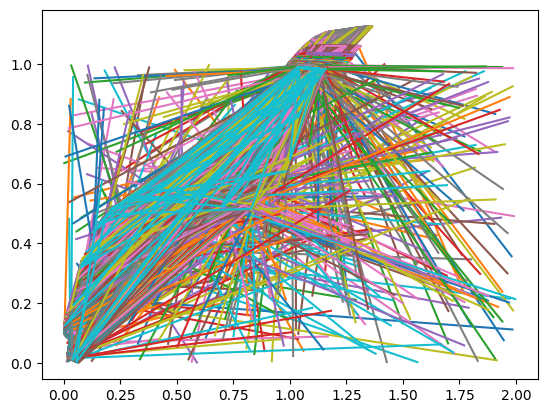

In [26]:
plt.plot(fms[:,:,0], fms[:,:,1])
plt.show()

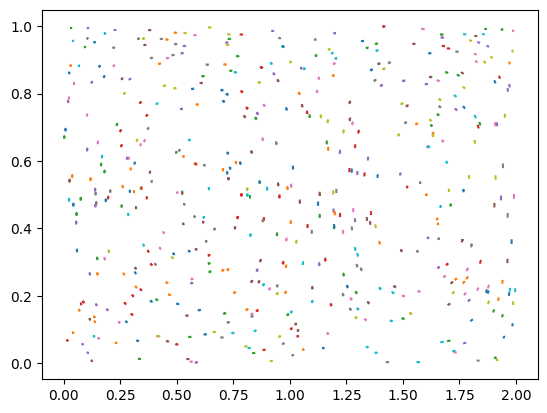

In [27]:
plt.plot(gt[:,:,0], gt[:,:,1])
plt.show()

In [33]:
fms[1, :, :]

array([[1.14880819, 1.10307215],
       [0.62935619, 0.62665832],
       [1.21311456, 1.11119913],
       [1.00917725, 1.01009384],
       [0.31554728, 0.32043866],
       [0.18430804, 0.1890155 ],
       [0.72537526, 0.71671966],
       [1.08972103, 1.07727502],
       [0.02111443, 0.02411028],
       [0.505771  , 0.50726035],
       [1.26395745, 1.0602226 ],
       [1.30301763, 1.05994006],
       [0.32564284, 0.33390309],
       [0.71414073, 0.69865617],
       [0.48546449, 0.48903613],
       [1.26319212, 1.06022237],
       [0.03626446, 0.04465646],
       [1.25949299, 1.03359708],
       [1.28797499, 1.03340816],
       [0.73807287, 0.71256539],
       [0.57303784, 0.56330983],
       [0.74666107, 0.72621637],
       [0.98663236, 0.98580593],
       [0.17240422, 0.18581406],
       [0.02042588, 0.01132997],
       [1.06150623, 1.02449711],
       [0.63277219, 0.62235084],
       [1.11049361, 1.02166023],
       [1.00189965, 1.00339766],
       [0.30879991, 0.32816104],
       [0.

In [34]:
gt[1, :, :]

array([[1.25648   , 0.226832  ],
       [1.06105   , 0.0400944 ],
       [0.523672  , 0.506776  ],
       [1.3292    , 0.559831  ],
       [0.583133  , 0.00219962],
       [0.362175  , 0.944176  ],
       [0.985406  , 0.364108  ],
       [1.6612    , 0.762521  ],
       [1.49368   , 0.770582  ],
       [0.184206  , 0.978394  ],
       [1.98064   , 0.362673  ],
       [1.77031   , 0.241656  ],
       [1.2961    , 0.209358  ],
       [0.785849  , 0.496519  ],
       [1.19489   , 0.978867  ],
       [1.10116   , 0.222008  ],
       [0.41198   , 0.0802343 ],
       [0.532741  , 0.470017  ],
       [1.17099   , 0.93063   ],
       [0.0683257 , 0.883724  ],
       [1.86988   , 0.215426  ],
       [1.65178   , 0.42947   ],
       [1.16187   , 0.65309   ],
       [0.371575  , 0.332856  ],
       [0.855221  , 0.273457  ],
       [0.616179  , 0.416619  ],
       [1.27333   , 0.190186  ],
       [1.31775   , 0.278279  ],
       [0.804779  , 0.0493835 ],
       [1.57039   , 0.00335675],
       [0.